##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Data augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/data_augmentation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial demonstrates manual image manipulations and augmentation using `tf.image`.

Data augmentation is a common technique to improve results and avoid overfitting, see [Overfitting and Underfitting](../keras/overfit_and_underfit.ipynb) for others.

## Setup

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

Let's check the data augmentation features on an image and then augment a whole dataset later to train a model.

Download [this image](https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg), by Von.grzanka, for augmentation.

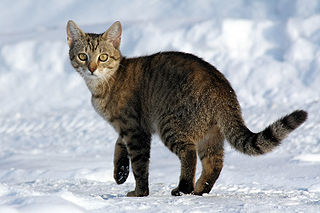

In [2]:
image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

Read and decode the image to tensor format.

In [3]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

A function to visualize and compare the original and augmented image side by side.

In [4]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

## Augment a single image

### Flipping the image
Flip the image either vertically or horizontally.

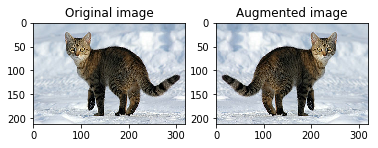

In [5]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### Grayscale the image
Grayscale an image.

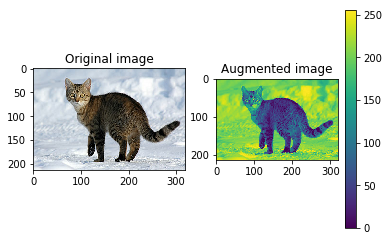

In [6]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

### Saturate the image
Saturate an image by providing a saturation factor.

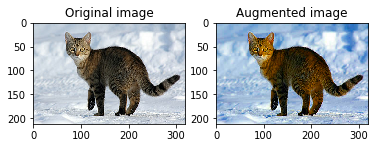

In [17]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

In [28]:
fimg = tf.cast(image, tf.int32)/255
hsvimg = tf.image.rgb_to_hsv(fimg)

In [32]:
tf.image.rgb_to_hsv(fimg)[:3,:3,:]

<tf.Tensor: shape=(3, 3, 3), dtype=float64, numpy=
array([[[0.58333333, 0.11009174, 0.85490196],
        [0.58333333, 0.11009174, 0.85490196],
        [0.58333333, 0.11009174, 0.85490196]],

       [[0.58333333, 0.10958904, 0.85882353],
        [0.58333333, 0.10958904, 0.85882353],
        [0.58333333, 0.10958904, 0.85882353]],

       [[0.58333333, 0.10909091, 0.8627451 ],
        [0.58333333, 0.10909091, 0.8627451 ],
        [0.58333333, 0.10909091, 0.8627451 ]]])>

In [35]:
tf.image.rgb_to_hsv(tf.cast(saturated, tf.int32)/255)[:3,:3,:]

<tf.Tensor: shape=(3, 3, 3), dtype=float64, numpy=
array([[[0.58333333, 0.33027523, 0.85490196],
        [0.58333333, 0.33027523, 0.85490196],
        [0.58333333, 0.33027523, 0.85490196]],

       [[0.58333333, 0.32876712, 0.85882353],
        [0.58333333, 0.32876712, 0.85882353],
        [0.58333333, 0.32876712, 0.85882353]],

       [[0.58333333, 0.32727273, 0.8627451 ],
        [0.58333333, 0.32727273, 0.8627451 ],
        [0.58333333, 0.32727273, 0.8627451 ]]])>

### Change image brightness
Change the brightness of image by providing a brightness factor.

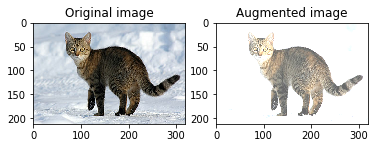

In [36]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

### Rotate the image
Rotate an image by 90 degrees.

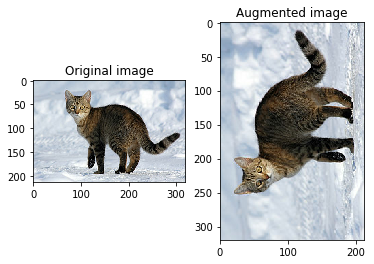

In [37]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Center crop the image
Crop the image from center upto the image part you desire.

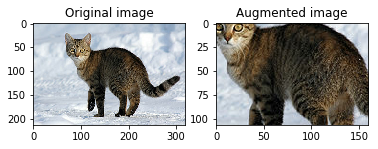

In [38]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

See the `tf.image` reference for details about available augmentation options.

## Augment a dataset and train a model with it

Train a model on an augmented dataset.

Note: The problem solved here is somewhat artificial. It trains a densely connected network to be shift invariant by jittering the input images. It's much more efficient to use convolutional layers instead.

In [40]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

W0507 23:23:05.056941 4498257344 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


Write a function to augment the images. Map it over the the dataset. This returns a dataset that augments the data on the fly.

In [14]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label

In [15]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

Create the augmented dataset.

In [16]:
augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

And a non-augmented one for comparison.

In [17]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

Setup the validation dataset. This doesn't change whether or not you're using the augmentation.

In [18]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

Create and compile the model. The model is a two layered, fully-connected neural network without convolution.

In [19]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

Train the model, **without** augmentation:

In [20]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 1s 38ms/step - loss: 0.7947 - accuracy: 0.7485 - val_loss: 0.3258 - val_accuracy: 0.9008
Epoch 2/50
32/32 [==============================] - 1s 23ms/step - loss: 0.1551 - accuracy: 0.9512 - val_loss: 0.3558 - val_accuracy: 0.9033
Epoch 3/50
32/32 [==============================] - 1s 23ms/step - loss: 0.0937 - accuracy: 0.9692 - val_loss: 0.3041 - val_accuracy: 0.9170
Epoch 4/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0413 - accuracy: 0.9839 - val_loss: 0.3262 - val_accuracy: 0.9207
Epoch 5/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0206 - accuracy: 0.9927 - val_loss: 0.3151 - val_accuracy: 0.9272
Epoch 6/50
32/32 [==============================] - 1s 23ms/step - loss: 0.0179 - accuracy: 0.9932 - val_loss: 0.3467 - val_accuracy: 0.9246
Epoch 7/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0351 - accuracy: 0.9907 - val_loss: 0.3731 - val_accuracy: 0.9227
Epoch 8/50
32

Train it again with augmentation:

In [21]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 1s 35ms/step - loss: 2.3106 - accuracy: 0.3115 - val_loss: 1.2095 - val_accuracy: 0.6655
Epoch 2/50
32/32 [==============================] - 1s 23ms/step - loss: 1.3821 - accuracy: 0.5371 - val_loss: 0.7040 - val_accuracy: 0.7943
Epoch 3/50
32/32 [==============================] - 1s 22ms/step - loss: 0.9761 - accuracy: 0.6709 - val_loss: 0.5867 - val_accuracy: 0.8518
Epoch 4/50
32/32 [==============================] - 1s 23ms/step - loss: 0.7830 - accuracy: 0.7437 - val_loss: 0.4247 - val_accuracy: 0.8816
Epoch 5/50
32/32 [==============================] - 1s 23ms/step - loss: 0.6546 - accuracy: 0.7715 - val_loss: 0.3521 - val_accuracy: 0.8943
Epoch 6/50
32/32 [==============================] - 1s 23ms/step - loss: 0.5795 - accuracy: 0.8057 - val_loss: 0.3036 - val_accuracy: 0.9034
Epoch 7/50
32/32 [==============================] - 1s 22ms/step - loss: 0.4934 - accuracy: 0.8350 - val_loss: 0.2950 - val_accuracy: 0.9088
Epoch 8/50
32

## Conclusion:

In this example the augmented model converges to an accuracy ~95% on validation set. This is slightly higher (+1%) than the model trained without data augmentation.

(0.75, 1.0)

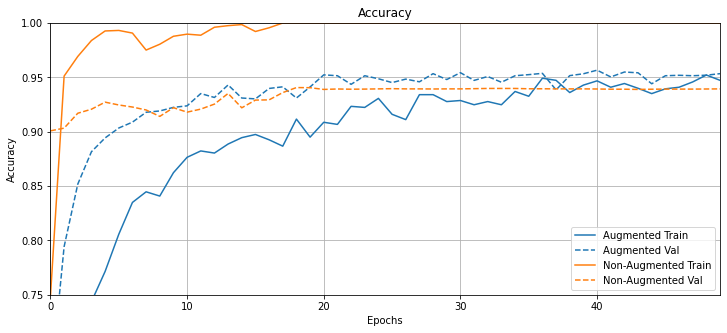

In [22]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])

In terms of loss, the non-augmented model is obviously in the overfitting regime. The augmented model, while a few epoch slower, is still training correctly and clearly not overfitting.

(0.0, 1.0)

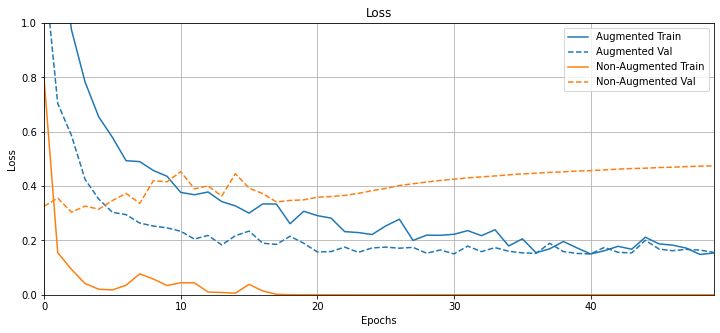

In [23]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])